# **Importing Libraries**

In [98]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# **Reading Data**

In [99]:
# Load the data
df = pd.read_csv('single.csv')
# df = df.sample(frac=0.2, random_state=42)
# Replace null values with 0
df.fillna(0, inplace=True)

In [ ]:
df.shape

(1048575, 11)

In [ ]:
df.columns

Index(['Trk', 'Frame', 'x', 'y', 'w', 'h', 'overall_cls', 'Smoothed_dir',
       'Vx_Instant_Not_Smoothed(kmph)', 'Vy_Instant_Not_Smoothed(kmph)',
       'Vxy_smoothed'],
      dtype='object')

In [ ]:
# df['Frame'].unique().shape

In [ ]:
# df['Frame'].value_counts().idxmax()
# df['Frame'].value_counts().max()

*   This code first calculates the top 700 frames with the maximum repetitions using the value_counts() function, which counts the occurrences of each unique value in the 'Frame' column.
*   Then, it filters the DataFrame to keep only the rows with the 'Frame' values present in the list of top 700 frames using the isin() function.



In [ ]:
# Get the top 700 frames with the maximum repetitions
top_700_frames = df['Frame'].value_counts().head(700).index.tolist()

# Filter the DataFrame to keep only the rows with the top 700 frames
# We use the isin() function to check if the 'Frame' values are in the list of top 700 frames
df = df[df['Frame'].isin(top_700_frames)]

In [ ]:
df.shape

(113947, 11)

In [ ]:
df.head()

,Trk,Frame,x,y,w,h,overall_cls,Smoothed_dir,Vx_Instant_Not_Smoothed(kmph),Vy_Instant_Not_Smoothed(kmph),Vxy_smoothed
340,1,342,1234,1313,155,74,car,EW,-0.281877,-0.008542,0.282902
341,1,343,1234,1313,155,74,car,EW,-0.281053,-0.008517,0.282164
342,1,344,1234,1313,155,74,car,EW,-0.280233,-0.008492,0.281397
343,1,345,1234,1313,155,74,car,EW,-0.279419,-0.008467,0.280608
344,1,346,1234,1312,155,74,car,EW,-0.278609,-0.016885,0.279862


# **Feature extraction**


- Distance traveled is computed using the Euclidean distance formula based on the vehicle's position coordinates.
- Velocity is determined by finding the difference in distance between consecutive frames, representing the rate of change of position over time.
- Acceleration is derived from the change in velocity between consecutive frames, indicating how quickly the velocity is changing.
- Speed is calculated by taking the magnitude of the velocity vector, providing the overall rate of motion regardless of direction.

In [ ]:
# Feature extraction
# Calculate the distance travelled
df['distance'] = np.sqrt(df['x']**2 + df['y']**2)

# Calculate the velocity by taking the difference in distance between consecutive frames
df['velocity'] = df['distance'].diff()

# Calculate the acceleration by taking the difference in velocity between consecutive frames
df['acceleration'] = df['velocity'].diff()

# Calculate the speed using the formula: sqrt(Vx^2 + Vy^2)
df['speed'] = (df['Vx_Instant_Not_Smoothed(kmph)']**2 + df['Vy_Instant_Not_Smoothed(kmph)']**2)**0.5

# Spatial-Temporal Features
# Calculate the average velocity over the past 5, 10, and 15 frames
df['avg_velocity_50'] = df['velocity'].rolling(window=50).mean()
df['avg_velocity_100'] = df['velocity'].rolling(window=100).mean()

# Stop Patterns
# Calculate the number of stops in the past 10, 20, and 30 frames
df['stops_5000'] = df['velocity'].rolling(window=5000).apply(lambda x: (x == 0).sum())

<ipython-input-82-7634f3dc587c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = np.sqrt(df['x']**2 + df['y']**2)
<ipython-input-82-7634f3dc587c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity'] = df['distance'].diff()
<ipython-input-82-7634f3dc587c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

*   To identify different stop patterns in a vehicle trajectory dataset.

*   It defines thresholds to distinguish hard stops, momentary stops, and moving vehicles based on velocity and acceleration.

*   Binary indicators are then created for each stop type, and the data is split into training and testing sets for further analysis or model training.


In [ ]:
# Define thresholds for identifying different stop patterns
hard_stop_threshold = 0.00001  # Threshold for identifying a hard stop based on speed difference
momentary_stop_threshold = 0.6 # Threshold for identifying a momentary stop based on average velocity
moving_vehicle_threshold = 10.0  # Threshold for identifying a moving vehicle based on velocity

# Identify hard stops based on speed difference
df['hard_stop'] = (abs(df['speed'].diff()) <= hard_stop_threshold)

# Identify moving vehicles based on velocity and acceleration
df['moving_vehicle'] = (df['velocity'] > moving_vehicle_threshold) & (df['acceleration'] != 0)

# Identify momentary stops based on average velocity and velocity
df['momentary_stop'] = (abs(df['avg_velocity_50']) < momentary_stop_threshold) & (df['velocity'] != 0)

# Prepare the data for the model
X = df[['distance', 'velocity', 'acceleration']]
# Combine stop types for the target variable
y = df['hard_stop'] | df['momentary_stop'] | df['moving_vehicle']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Fitting**

- Missing values in the training and testing data are filled with the mean of each feature using the SimpleImputer class with the strategy set to 'mean'.
- The RandomForestClassifier model is instantiated.
- The model is trained on the imputed training data.
- Predictions are made on the imputed testing data.
- Accuracy score and a classification report, including precision, recall, and F1-score, are printed to evaluate the model's performance.

In [ ]:
# Fill missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')  # Instantiate the SimpleImputer with 'mean' strategy
X_train_imputed = imputer.fit_transform(X_train)  # Fill missing values in training data and transform it
X_test_imputed = imputer.transform(X_test)  # Fill missing values in testing data using the imputer fitted on training data

# Train the model
model = RandomForestClassifier()  # Instantiate the RandomForestClassifier model
model.fit(X_train_imputed, y_train)  # Train the model on imputed training data and corresponding labels

# Evaluate the model
y_pred = model.predict(X_test_imputed)  # Make predictions on imputed testing data
print(accuracy_score(y_test, y_pred))  # Print the accuracy score of the model
print(classification_report(y_test, y_pred))  # Print the classification report of the model's performance


0.943483984203598
              precision    recall  f1-score   support

       False       0.96      0.94      0.95     12438
        True       0.93      0.95      0.94     10352

    accuracy                           0.94     22790
   macro avg       0.94      0.94      0.94     22790
weighted avg       0.94      0.94      0.94     22790



# **Plotting the result**

*   To create a scatter plot visualizing the trajectory data with different categories marked by color were red ponins represent hard stop, blue points represent mommomentary stop and green points represent moving vehicles.

*   It extracts the x and y coordinates along with labels for hard stops, momentary stops, and moving vehicles from the dataframe.

*   Then, it plots each category with a distinct color and adds labels, a title, and a legend for clarity. Finally, it displays the plot.





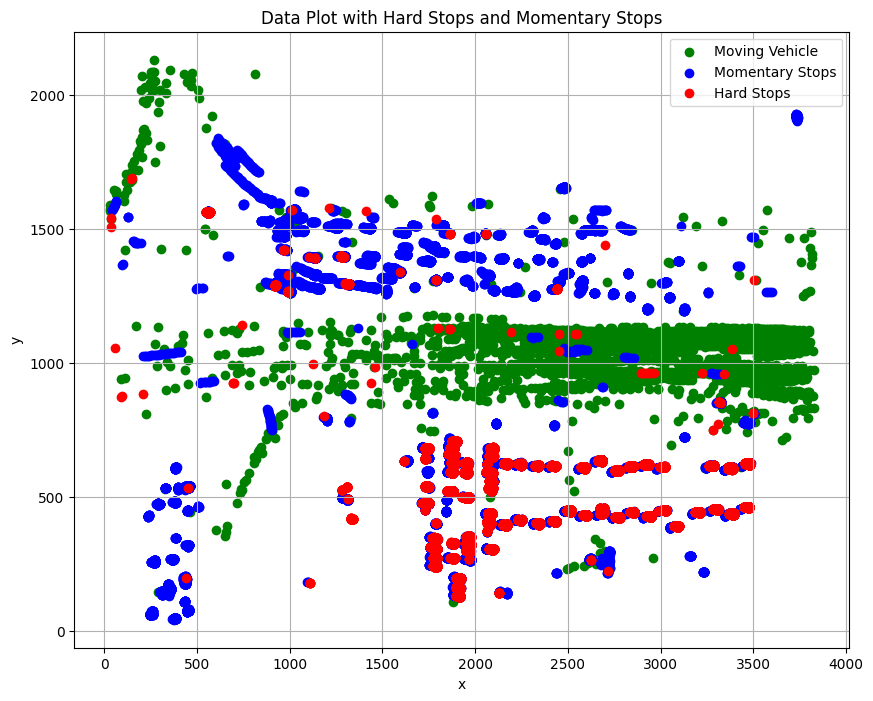

In [ ]:
# Extract relevant columns for plotting
x = df['x']  # Extracting the x-coordinate data
y = df['y']  # Extracting the y-coordinate data
hard_stop = df['hard_stop']  # Extracting the hard_stop labels
momentary_stop = df['momentary_stop']  # Extracting the momentary_stop labels
moving_vehicle = df['moving_vehicle']  # Extracting the moving_vehicle labels

# Plot the data
plt.figure(figsize=(10, 8))  # Creating a new figure with a specific size

# Plot points of moving vehicles
plt.scatter(x[moving_vehicle], y[moving_vehicle], c='green', label='Moving Vehicle')

# Plot points of momentary stops
plt.scatter(x[momentary_stop], y[momentary_stop], c='blue', label='Momentary Stops')

# Plot points of hard stops
plt.scatter(x[hard_stop], y[hard_stop], c='red', label='Hard Stops')

# Add labels and title
plt.xlabel('x')  # Adding label for x-axis
plt.ylabel('y')  # Adding label for y-axis
plt.title('Data Plot with Hard Stops and Momentary Stops')  # Adding title to the plot

# Add legend
plt.legend()  # Adding legend to distinguish between different categories

# Show plot
plt.grid(True)  # Adding grid lines to the plot
plt.show()  # Displaying the plot
